Set up

In [5]:
import sys
sys.path.append('../../src')
from constants import AMINO_ACID_INDICES, IMMUNOGENICITY_ONE_HOT
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [6]:
trainpath = "C:/Users/micha/Downloads/spikeprot_train.txt"

In [7]:
with open(trainpath) as f:
    train = f.read().splitlines()

In [8]:
train_dataset_aa_indices = []
for aa_sequance in train:
    aa_sequance_indices = []
    for aa in aa_sequance:
        aa_sequance_indices.append(AMINO_ACID_INDICES[aa])
    train_dataset_aa_indices.append(aa_sequance_indices)
train_dataset_aa_indices = np.array(train_dataset_aa_indices)


In [9]:
def one_hot_sequance(sequance):
    return np.eye(21)[sequance].flatten()

train_dataset_one_hot = np.apply_along_axis(one_hot_sequance, 1, train_dataset_aa_indices)

Now we will work with alligned sequances (note that the generative models return alligned sequances)

First we will plot PCA results for training set

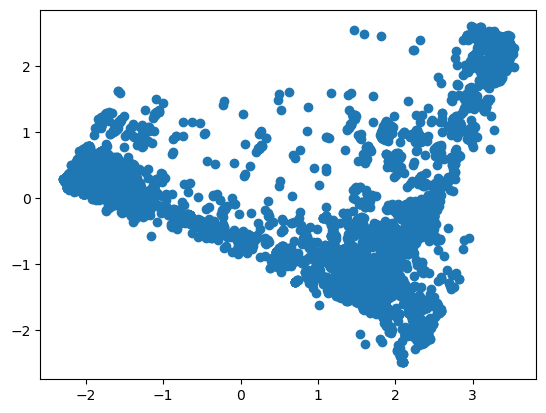

In [10]:
pca = PCA(n_components=2)
result = pca.fit_transform(train_dataset_one_hot)
plt.scatter(result[:,0],result[:,1])

Now we will plot evaluate_protein on top of above plot.

In [11]:
evaluate_protein = train_dataset_one_hot[5] # replace this with the result of your model you are evaluating
pca.transform([evaluate_protein]) # If you are evaluating list of proteins, get rid of [] in this expression

array([[ 2.38118757, -2.11961384]])

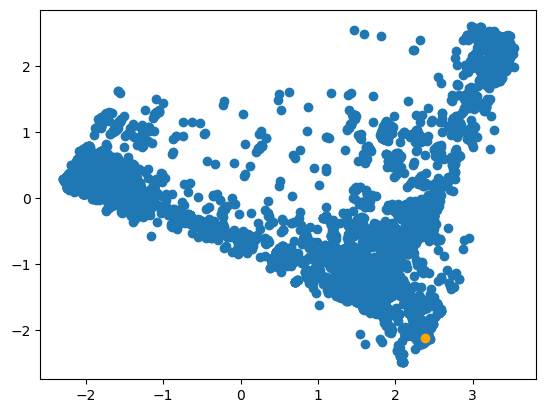

In [12]:
result_evaluate_protein=pca.transform([evaluate_protein])
plt.scatter(result[:,0],result[:,1])
plt.scatter(result_evaluate_protein[:,0],result_evaluate_protein[:,1],c="orange")

We can see that evaulate protein which is orange lies in the right region

Now we will find conserved regions

In [13]:
train_charcters = list(map(lambda string : [x for x in string], train)) # convert each string (sequance of AAs) to list of characters

sequances = np.array(train_charcters)

conserved = [(i,s[0])  for (i, s) in enumerate(sequances.T) if len(np.unique(s)) == 1]

conserved_indexes = [i for (i, c) in conserved]
conserved_aa = [c for (i, c) in conserved]

This is a list of positions and names of AAs that are conserved in training dataset

In [14]:
print("Number of conserved AA: "+ str(len(conserved)))
conserved

Number of conserved AA: 82


[(49, 'L'),
 (240, 'L'),
 (316, 'P'),
 (322, 'C'),
 (357, 'C'),
 (364, 'N'),
 (400, 'C'),
 (408, 'L'),
 (412, 'C'),
 (419, 'D'),
 (437, 'G'),
 (443, 'N'),
 (444, 'Y'),
 (452, 'G'),
 (453, 'C'),
 (488, 'D'),
 (547, 'G'),
 (552, 'T'),
 (562, 'F'),
 (566, 'G'),
 (576, 'S'),
 (578, 'K'),
 (599, 'D'),
 (611, 'C'),
 (622, 'G'),
 (626, 'S'),
 (654, 'W'),
 (669, 'G'),
 (683, 'C'),
 (684, 'D'),
 (686, 'P'),
 (692, 'C'),
 (720, 'Y'),
 (732, 'Y'),
 (743, 'F'),
 (758, 'K'),
 (763, 'C'),
 (766, 'Y'),
 (774, 'C'),
 (781, 'Y'),
 (785, 'C'),
 (799, 'Q'),
 (841, 'S'),
 (865, 'C'),
 (876, 'C'),
 (898, 'Y'),
 (922, 'P'),
 (923, 'F'),
 (926, 'Q'),
 (930, 'R'),
 (931, 'F'),
 (933, 'G'),
 (944, 'N'),
 (945, 'Q'),
 (953, 'N'),
 (976, 'V'),
 (978, 'N'),
 (984, 'L'),
 (987, 'L'),
 (990, 'Q'),
 (991, 'L'),
 (995, 'F'),
 (996, 'G'),
 (1002, 'L'),
 (1005, 'I'),
 (1019, 'D'),
 (1020, 'R'),
 (1025, 'R'),
 (1053, 'K'),
 (1057, 'C'),
 (1064, 'R'),
 (1068, 'C'),
 (1073, 'H'),
 (1076, 'S'),
 (1078, 'P'),
 (1084, 'G'),


In [15]:
conserved_aa_one_hot = np.array([one_hot_sequance(AMINO_ACID_INDICES[seq]) for seq in conserved_aa])

In [16]:
# Checks whether all the required aminoacids are conserved
# Input: sequance of aminocids encoded by letters and -
# Output: Boolean indicating whether AAs are conserved in the sequance
def check_conserved_from_aa_sequance(seq):
    return all(seq[conserved_indexes] == conserved_aa)


# Checks whether all the required aminoacids are conserved
# Input: sequance of aminocids encoded by one hot encoding
# Output: Boolean indicating whether AAs are conserved in the sequance
def check_conserved_from_one_hot(seq):
    return all((seq.reshape(-1,21)[conserved_indexes] == conserved_aa_one_hot).flatten())


eval_sequance= sequances[5]
check_conserved_from_aa_sequance(eval_sequance)

check_conserved_from_one_hot(evaluate_protein)

True

Now we will work with unalligned sequances, i.e. simply sequances of letters of arbitrary length

In this notebook we will evaluate protein alpha.txt using the reference protein wuhan.txt 

In [17]:
with open("../data/wuhan.fasta") as f:
    wuhan = f.read()

with open("../data/alpha.fasta") as f:
    alpha = f.read()

In [18]:

# taken from https://github.com/hcgasser/SpikeVAE/blob/main/evaluation/get_point_mutation_list.py
def generate_point_mutation_list(original_sequence, mutated_sequence):
    point_mutation_list = ""
    for res_index, residue_tuple in enumerate(zip(original_sequence, mutated_sequence)):
        orig_res = residue_tuple[0]
        mut_res = residue_tuple[1]
        if mut_res == "-" or orig_res == "-":
            # potentially an insertion or deletion -ignore
            continue
        elif mut_res != orig_res:
            # a mutation - add it to the list
            point_mutation_list+=f"{orig_res}{res_index+1}{mut_res}\n"
        else:
            # no mutation - ignore
            continue

    return point_mutation_list

In [19]:
from Bio.Seq import Seq 
import Bio
wuhan_seq = Seq(wuhan) 
alpha_seq = Seq(alpha)

In [20]:
from Bio.pairwise2 import format_alignment
alignments = Bio.pairwise2.align.globalxs(wuhan_seq, alpha_seq, score_only=False, open=-1, extend=-0.1)
wuhan_allign = alignments[0].seqA
alpha_allign = alignments[0].seqB

mutations = generate_point_mutation_list(wuhan_allign,alpha_allign)

print(mutations)

L18F
D80A
D215G
K417N
E484K
N501Y
D614G
A701V



In [21]:
wuhan_allign = wuhan_allign.replace('-','X')

In [22]:
 with open('wuhan_ddgan.fasta', 'w') as f:
            print(f'>Ref sequance', file=f)
            print(wuhan_allign, file=f)

 with open('alpha_ddgan_mutations.fasta', 'w') as f:
            print(mutations, file=f)